##### ResNet Autoencoder (AE) for ECAL DQM 
EE Occupancy

In [1]:
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import ConcatDataset
from torch.utils.data import sampler
from torch.utils.data import DataLoader
import random
import copy
import argparse

import time
import os, glob
# Specify which gpuid to use
os.environ["CUDA_VISIBLE_DEVICES"]=str(0)

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator, FixedLocator
%matplotlib inline

In [2]:
f = pq.ParquetFile('DATA/500ev_EE_ECALDQM_run315506.parquet')
print(f.metadata)
print(f.schema)

  created_by: parquet-cpp version 1.5.1-SNAPSHOT
  num_columns: 7
  num_rows: 88
  num_row_groups: 88
  format_version: 1.0
  serialized_size: 63547
required group field_id=0 schema {
  optional int64 field_id=1 run;
  optional double field_id=2 PU;
  optional group field_id=3 EEOccupancyTask_EEOT_digi_occupancy_EE_p (List) {
    repeated group field_id=4 list {
      optional group field_id=5 item (List) {
        repeated group field_id=6 list {
          optional double field_id=7 item;
        }
      }
    }
  }
  optional group field_id=8 EEOccupancyTask_EEOT_digi_occupancy_EE_m (List) {
    repeated group field_id=9 list {
      optional group field_id=10 item (List) {
        repeated group field_id=11 list {
          optional double field_id=12 item;
        }
      }
    }
  }
  optional double field_id=13 lumi_delivered;
  optional int64 field_id=14 ls;
  optional double field_id=15 lumi;
}



In [3]:
parsing = True
parsing = False
global frequency
if parsing:
    parser = argparse.ArgumentParser(description='Process some integers.')
    parser.add_argument('-e', '--epochs', default=50, type=int, help='Number of training epochs.')
    parser.add_argument('-f', '--frequency', default=0.1, type=float, help='Frequency of hot towers.')
    parser.add_argument('-d', '--data', default=1.0, type=float, help='Percentage of training data set.')
    parser.add_argument('-n', '--name', default='untitled', type=str, help='Name of experiment.')
    #parser.add_argument('-c', '--cuda', default=1, type=int, help='Which gpuid to use.')

    args = parser.parse_args()

    epochs = args.epochs
    frequency = args.frequency
    data_percent = args.data
    expt_name = args.name
    #os.environ["CUDA_VISIBLE_DEVICES"]=str(args.cuda)
else:
    epochs = 1
    frequency = 0
    data_percent = 1
    expt_name = "untitled"

In [4]:
run_logger = True
if run_logger:
    if not os.path.isdir('LOGS'):
        os.makedirs('LOGS')
    file = open('LOGS/%s.log'%(expt_name), 'w')
    #for d in ['MODELS', 'METRICS','PLOTS']:
    for d in ['MODELS', 'PLOTS']:
        if not os.path.isdir('%s/%s'%(d, expt_name)):
            os.makedirs('%s/%s'%(d, expt_name))

def logger(s):
    global file, run_logger
    if run_logger:
        file.write('%s\n'%str(s))
        
logger('>> Experiment: %s'%(expt_name))

# Pre-processing routines and plotting

Plotting functions:

In [5]:
def plot_endcap(img1, vmin=0., vmax=1., cmap='viridis', label='Endcap Occupancies', title='', gridlines=True):
    if type(img1) == type(torch.Tensor([])): img1 = img1.cpu().numpy()
    img1 = img1.squeeze()
    assert len(img1.shape) == 2
    
    fig, ax = plt.subplots()
    plt.title(title)
    im1 = ax.imshow(img1, vmin=vmin, vmax=vmax, cmap=cmap, origin='lower')
    ax.figure.colorbar(im1, ax=ax, fraction=0.0228, pad=0.015, label=label)
    
    if gridlines:
        # Since imshow() places tick marks at center of image pixel...
        off = 0.5
        # Set image coordinates where ticks should appear...
        ax.set_xticks(np.arange(0,22,2)-off)
        ax.set_yticks(np.arange(0,22,2)-off)
        # Set what values should be displayed at these coordinates
        ax.set_xticklabels(np.arange(-10,12,2))
        ax.set_yticklabels(np.arange(-10,12,2))
        # Make ticks face inward
        ax.xaxis.set_tick_params(direction='in', which='major', length=6.)
        ax.xaxis.set_tick_params(direction='in', which='minor', length=3.)
        ax.yaxis.set_tick_params(direction='in', which='major', length=6.)
        ax.yaxis.set_tick_params(direction='in', which='minor', length=3.)
        # HORIZONTAL DASHES
        for i in np.arange(0, 20, 2):
            x1, x2 = 0, 20
            y1, y2 = i, i
            ax.plot([x1-off, x2-off],[y1-off, y2-off], linewidth=1, linestyle='--', color='black')
        # VERTICAL DASHES
        for i in np.arange(0, 20, 2):
            x1, x2 = i, i
            y1, y2 = 0, 20
            ax.plot([x1-off, x2-off],[y1-off, y2-off], linewidth=1, linestyle='--', color='black')

    plt.show()
    plt.close()

Pileup Correction functions:

In [6]:
def sum_endcap(occupancies): 
    #sums all occupancies in an image
    occupancy = 0
    occupancies = occupancies[0]
    for row in occupancies:
        for entry in row:
            occupancy += entry
    return occupancy

def apply_PU_corr(img, endcap, pileup): #endcap p or m
    corrections = {'p': 2273.76339581, 'm': 2138.95653637}
    intercepts = {'p': 42675.04864709836, 'm': 43724.17470295953}
    
    occupancies = sum_endcap(img)
    
    normalized = np.array([img[0]/(corrections[endcap]*pileup+intercepts[endcap])])
    
    return normalized

def apply_PU_corr_batch(X, PUs, endcap = 'm'):
    correction = {'p': 2273.76339581, 'm': 2138.95653637}
    intercept = {'p': 42675.04864709836, 'm': 43724.17470295953}
    for i in range(X.size()[0]):
        #occupancies = torch.Float(sum_endcap(X[i]))
        X[i] = X[i]/(torch.FloatTensor([correction[endcap]*PUs[i]+intercept[endcap]]).cuda())
    return X*100
        

Anomaly transform functions:

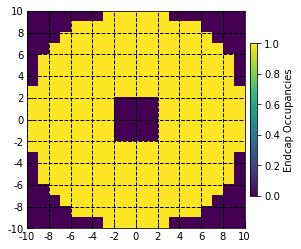

[(5, 10), (6, 5), (15, 17), (6, 1), (18, 8), (7, 11), (16, 17)]
Problem coords EE+ [(0, 10), (3, 6), (5, 16), (7, 1), (9, 0), (15, 15)]
Problem coords EE- [(5, 10), (6, 5), (15, 17), (6, 1), (18, 8), (7, 11), (16, 17)]


In [7]:
def find_endcap_coords(sample_img):
    #returns a list of coordinates that belong to the endcap, plus an "opaque" endcap
    img = sample_img[0]
    endcap_pixels = [] # Holds coords for pixels belonging to endcap
    in_endcap = np.zeros((20, 20)) # Holds booleans for each position (if it's in the endcap or not)
    for i in range(len(img)): # iterate through rows and cols
        for j in range(len(img[0])):
            if img[i][j] == 0: # if an entry is empty...
                white_adjacents = 0 # we check its neighbors!
                for (drow, dcol) in [(-1,0), (1,0), (0,1), (0,-1)]:
                    if i+drow < len(img) and j+dcol < len(img[0]):
                        if img[i+drow][j+dcol] == 0: white_adjacents += 1 # count non-diagonal adjacent empties
                if white_adjacents < 1: # no empty neighbors --> pixel belongs to endcap
                    in_endcap[i][j] = True
                    endcap_pixels.append((i,j))
                else: in_endcap[i][j] = False
            if img[i][j] != 0: 
                in_endcap[i][j] = True
                endcap_pixels.append((i,j))
            if [i,j] == [8,8] or [i,j] == [8,11] or [i,j] == [11,11] or [i,j] == [11,8]:
                in_endcap[i][j] = False
                endcap_pixels.remove((i,j))
    #return endcap_pixels, np.array(in_endcap)
    return endcap_pixels, np.array(in_endcap)

sample_img = np.array(f.read_row_group(0).to_pydict()['EEOccupancyTask_EEOT_digi_occupancy_EE_m'])
endcap_pixels = find_endcap_coords(sample_img)
plot_endcap(endcap_pixels[1])

# MAPS SHOWING KNOWN ANOMALIES (note that these are 100x100)
anomaly_map = pq.ParquetFile('500ev_EE_channelstatusmap_run319993.parquet')
anomaly_map_p = np.array(anomaly_map.read_row_group(0).to_pydict()['EEIntegrityClient_EEIT_EE_p_channel_status_map'])
anomaly_map_m = np.array(anomaly_map.read_row_group(0).to_pydict()['EEIntegrityClient_EEIT_EE_m_channel_status_map'])

# Rebin map from 100x100 to 20x20... returns problem coordinates and rebinned image
def rebin(img, threshold = 0.2):
    max_problems = threshold*25 #threshold level for flagging a 5x5 section as problematic
    img = img.squeeze()
    new_img = np.zeros((20,20))
    problem_coords = []
    for i in range(20):
        for j in range(20):
            problems = 0 #count problems inside of 5x5 chunk...
            for small_i in range(5):
                for small_j in range(5):
                    if img[5*i+small_i][5*j+small_j] > 0: problems += 1
            if problems >= max_problems: #flag 5x5 chunk...
                new_img[i][j] = 1
                problem_coords.append((i,j))
    #return problem_coords, np.array(new_img)
    return problem_coords, new_img

problem_coords_p, rebinned_p = rebin(anomaly_map_p)
problem_coords_m, rebinned_m = rebin(anomaly_map_m)
problem_coords_m.append((6,1))
problem_coords_m.append((18,8))
problem_coords_m.append((7,11))
problem_coords_m.append((16,17))
print(problem_coords_m)

print("Problem coords EE+", problem_coords_p)
print("Problem coords EE-", problem_coords_m)

# Determine pixels that belong to the endcap, but aren't known problems
def find_mutable_pixels(endcap_pixels, problem_coords):
    mutable_pixels = []
    for coords in endcap_pixels[0]:
        if coords not in problem_coords: mutable_pixels.append(coords)
    return [mutable_pixels]

mutable_pixels_p = find_mutable_pixels(endcap_pixels, problem_coords_p)
mutable_pixels_m = find_mutable_pixels(endcap_pixels, problem_coords_m)

#GENERATE RANDOM NUMBERS FOR ANOMALY TRANSFORMS
np.random.seed(0)
rand_list_m = np.random.randint(len(mutable_pixels_m[0]), size=10000000).tolist()
rand_list_p = np.random.randint(len(mutable_pixels_p[0]), size=10000000).tolist()


#APPLIES ANOMALIES TO IMAGE:
def apply_anom_transform(img, anom_index, endcap ='m'):
    if endcap == 'p': 
        mutable_pixels, rand_list = mutable_pixels_p, rand_list_p
    if endcap == 'm': 
        mutable_pixels, rand_list = mutable_pixels_m, rand_list_m
    img = img[0]
    new_img = copy.deepcopy(img).tolist()
    # select random pixel from mutable pixels:
    rand_index = rand_list[anom_index]
    #print("anomaly index: ", rand_index)
    anomaly_pixel_row, anomaly_pixel_col = mutable_pixels[0][rand_index]
    #print(anomaly_pixel_row, anomaly_pixel_col)
    new_img[anomaly_pixel_row][anomaly_pixel_col] = frequency*500*25
    return np.array([new_img]), [anomaly_pixel_row, anomaly_pixel_col]

# APPLY ANOMALIES AND PILEUP CORRECTION
def apply_anom_transform_corr(X, PUs, i, endcap ='m', anom=False):
    #pass in i to get anom index, PU and X are the batch size
    rand_indices = rand_list_m[i*3:(i+1)*3]
    anom_coords = []
    for j in range(X.size()[0]):
        if anom: 
            rand_index = rand_indices[0]
            #plot_endcap(X[j], vmax=X[j].max(), title='Original')
            anomalized, anom_pixels = apply_anom_transform(X[j], rand_index, endcap ='m')
            #plot_endcap(anomalized, vmax=anomalized.max(), title='Anomalized')
            X[j] = torch.Tensor(anomalized).cuda()
            anom_coords.append(anom_pixels)
            
    X = apply_PU_corr_batch(X, PUs)
    if anom: return X, anom_coords
    else: return X, None

Test our preprocessing/plotting functions:

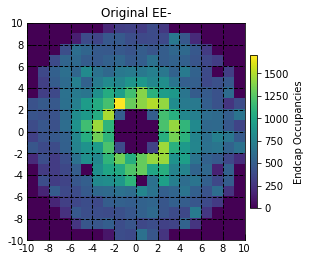

[3, 17]


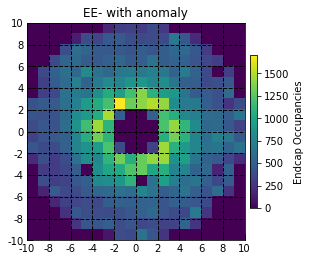

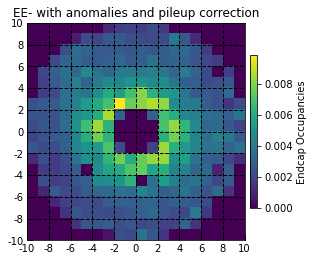

In [8]:
# TEST PLOT:
original = np.array(f.read_row_group(0).to_pydict()['EEOccupancyTask_EEOT_digi_occupancy_EE_m'])
plot_endcap(original, vmax=original.max(), title='Original EE-')
pileup = f.read_row_group(0).to_pydict()['PU'][0]

#original_norm = apply_PU_corr(original, 'm', pileup)

x, coords = apply_anom_transform(original, 1)
print(coords)
plot_endcap(x, vmax=x.max(), title='EE- with anomaly')
x = apply_PU_corr(x, 'm', pileup)

#plot_endcap(original_norm, vmax=original_norm.max(), title='Original EE-, normalized')
plot_endcap(x, vmax=x.max(), title='EE- with anomalies and pileup correction')

# Define input datasets
Define how samples are to be read in

In [9]:
class ParquetDataset(Dataset):
    def __init__(self, filename):
        self.parquet = pq.ParquetFile(filename)
        #self.cols = None # read all columns
        self.cols = ['EEOccupancyTask_EEOT_digi_occupancy_EE_m.list.item.list.item', 'PU']
    def __getitem__(self, index):
        #self.pileup = self.parquet.read_row_group(index).to_pydict()['PU'][0]
        data = self.parquet.read_row_group(index, columns=self.cols).to_pydict()
        data['EEOccupancyTask_EEOT_digi_occupancy_EE_m'] = np.float32((data['EEOccupancyTask_EEOT_digi_occupancy_EE_m'][0])).reshape(-1,20,20)
        #data['EEOccupancyTask_EEOT_digi_occupancy_EE_m'] = apply_anom_transform(data['EEOccupancyTask_EEOT_digi_occupancy_EE_m'])
        #data['EEOccupancyTask_EEOT_digi_occupancy_EE_m'] = apply_PU_corr(data['EEOccupancyTask_EEOT_digi_occupancy_EE_m'], 'm', self.pileup)
        data['PU'] = np.float32(data['PU'])
        return dict(data)
    def __len__(self):
        return self.parquet.num_row_groups

Split data into training, validation, and anomaly sets

In [10]:
#input_runs = ['DATA/500ev_EE_ECALDQM_run315543.parquet']
input_runs = glob.glob('DATA/500ev_EE_ECALDQM_run*.parquet')
print('>> N input runs: %s'%len(input_runs))
#print(input_runs)
assert len(input_runs) > 0

# Split input "good" dataset into training and validation sets
dset_good = ConcatDataset([ParquetDataset('%s'%r) for r in input_runs])
print('>> N good samples:',len(dset_good))
n_train, n_val = 81000*data_percent, 10463 #keep validation set fixed
n_train, n_val = int(n_train), int(n_val)
print('>> N train samples:',n_train)
print('>> N val samples:',n_val)
assert n_train+n_val <= len(dset_good)
# Shuffle indices before making split
# Files may be ordered by run or LS which should not be learned
idxs = np.random.permutation(len(dset_good))
idxs_train, idxs_val = idxs[:n_train], idxs[-n_val:]

# Training set needs to be shuffled
sampler_train = sampler.SubsetRandomSampler(idxs_train)
loader_train = DataLoader(dataset=dset_good, batch_size=32, num_workers=10, sampler=sampler_train, pin_memory=True)

# Do not shuffle validation set so can compare same image from epoch to epoch
sampler_val = sampler.SequentialSampler(idxs[-n_val:])
loader_val = DataLoader(dataset=dset_good, batch_size=4, num_workers=10, sampler=sampler_val)

# Define anomalous images:
# Apply transformation on same samples as in validation set
dset_anom = ConcatDataset([ParquetDataset('%s'%r) for r in input_runs])
loader_anom = DataLoader(dataset=dset_anom, batch_size=32, num_workers=10, sampler=sampler_val)

logger('>> N samples: Train: %d + Val: %d'%(len(idxs_train), len(idxs_val)))

>> N input runs: 190
>> N good samples: 91463
>> N train samples: 81000
>> N val samples: 10463


0.9999999999999997


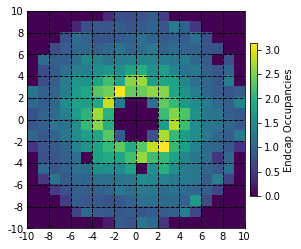

In [11]:
# sum all images in dataset
# divide by constant so mean occupancy across pixels is 1
avg_image = np.array([[0]*20]*20)
for i, data in enumerate(loader_train):
        X = data['EEOccupancyTask_EEOT_digi_occupancy_EE_m'].cuda()
        for image in X:
            avg_image = avg_image + image.cpu().numpy()
avg_image = avg_image/avg_image.mean()
print(avg_image.mean())
plot_endcap(avg_image, vmax=avg_image.max())

# Evaluation Function
Define what to do during the validation phase of the training. For instance, we can look at the original and AE-reconstructed image for some fixed sample at every epoch, and observe how the AE loss map between them changes during training.

In [12]:
def apply_thresh(img, thresh):
    img = img[0]
    for i in range(len(img)):
        for j in range(len(img[0])):
            if img[i][j] >= thresh:
                img[i][j] = 0
            else:
                img[i][j] = 1
    img = np.array(img)
    plot_endcap(img, vmax = 1, cmap = 'RdYlGn')
    
def do_eval(ae, val_loader, epoch, dstr='EEOccupancyTask_EEOT_digi_occupancy_EE_m', idx=0, anom = False):
    rand_index = 0
    loss_ = []
    loss_map_anom=[]
    loss_map = []
    
    eta_diff_norm = []
    eta_diff_anom = []
    
    R_lmap = []
    R_lap_anom = []
    eta_tmap = []
    eta_anom_tmap = []
    
    #TESTING LOW LOSS ANOMALIES
    low_loss_anoms = np.array([[0]*20]*20) #make empty endcap
    
    now = time.time()
    #print("loader length", len(val_loader.dataset))
    for i, data in enumerate(val_loader):
        X = data[dstr].float().cuda()
        PUs = data['PU']#.numpy()[0]
        if not anom:
            X, anom_coords = apply_anom_transform_corr(X, PUs, i, endcap ='m', anom=False)
        else:
            X, anom_coords = apply_anom_transform_corr(X, PUs, i, endcap ='m', anom=True)
        
        #break

        
        #Xreco = torch.div(ae(X.float()),torch.from_numpy(avg_image).cuda().float())
        #X = torch.div(X,torch.from_numpy(avg_image).cuda().double())
        
        Xreco = ae(X)
        
        
        Xreco[0] = torch.from_numpy(np.divide(Xreco[0].detach().cpu().numpy(),avg_image))
        Xreco[1] = torch.from_numpy(np.divide(Xreco[1].detach().cpu().numpy(),avg_image))
        if Xreco.size() == 4:
            Xreco[2] = torch.from_numpy(np.divide(Xreco[2].detach().cpu().numpy(),avg_image))
            Xreco[3] = torch.from_numpy(np.divide(Xreco[3].detach().cpu().numpy(),avg_image))
            #Xreco[4] = torch.from_numpy(np.divide(Xreco[4].detach().cpu().numpy(),avg_image))
        
        X[0] = torch.from_numpy(np.divide(X[0].cpu().numpy(),avg_image))
        X[1] = torch.from_numpy(np.divide(X[1].cpu().numpy(),avg_image))
        if X.size() == 4:
            X[2] = torch.from_numpy(np.divide(X[2].cpu().numpy(),avg_image))
            X[3] = torch.from_numpy(np.divide(X[3].cpu().numpy(),avg_image))
            #X[4] = torch.from_numpy(np.divide(X[4].cpu().numpy(),avg_image))
            
        
        # By default, torch.mse_loss takes batch-averaged loss
        # During validation phase, want to know EB loss map for each sample (LS) in the batch
        # reduction='none' calculates loss on each *pixel* in image
        #losses = F.mse_loss(Xreco, X, reduction='none')#.detach().cpu().numpy()/avg_image
        losses = F.mse_loss(Xreco, X, reduction='none')
        if losses.shape[0] != 4:
            pass
        else:
            #losses = torch.mul(torch.mul(losses[0],losses[1]),losses[2]).unsqueeze(0)
            losses = torch.mul(torch.mul(torch.mul(losses[0],losses[1]),losses[2]),losses[3]).unsqueeze(0)
            #losses = torch.mul(torch.mul(torch.mul(torch.mul(losses[0],losses[1]),losses[2]),losses[3]),losses[4]).unsqueeze(0)
        
        losses = losses.detach().cpu()
        
        idx = i
        if idx == 1:
            # Original image:
            print(' >> original image:')
            img = X[idx].detach().cpu().numpy()
            plot_endcap(img)
            #plot_endcap(X)
            # AE-reconstructed image
            print(' >> AE-reco image:')
            img_reco = Xreco[idx].detach().cpu().numpy()
            plot_endcap(img_reco)
            # Loss map
            print(' >> loss map:')
            img_loss = F.mse_loss(Xreco[idx], X[idx], reduction='none').detach().cpu().numpy()
            print(f'Anom coords: {anom_coords}')
            plot_endcap(img_loss, vmax=0.2, cmap='jet', label="Loss") 
            apply_thresh(img_loss, 0.1467)
        if not anom:
            loss_.append(losses.tolist())
        else: #IF ANOMALOUS
            #j = 0
            #print(losses.size())
            for sample in losses:
                img_losses = sample[0][anom_coords[0][0]][anom_coords[0][1]]
                if img_losses < 0.00001:
                    new_opaque_endcap = copy.copy(endcap_pixels[1])
                    new_opaque_endcap[anom_coords[0][0]][anom_coords[0][1]] = False
                    #plot_endcap(sample)
                    low_loss_anoms[anom_coords[0][0]][anom_coords[0][1]] += 1
                    #plot_endcap(losses.numpy(), vmax=0.2, cmap='jet', label="Loss") 
                loss_.append(img_losses.tolist())
                #j += 1

    now = time.time() - now
    
    if not anom:
        loss_ = np.concatenate(loss_).flatten()
    else: loss_ = np.array(loss_)

    #if anom: print(loss_)
    #plt.hist(loss_, histtype='step',bins=240,log=True, label='Loss', color='orange',linewidth='2')
    #plt.legend()
    #plt.xlabel('AE Loss', size='14')
    #plt.savefig('lossmap.png', bbox_inches='tight')
    #plt.show()
    
    mean = 0
    if len(loss_) > 0:
        mean = sum(loss_)/len(loss_)
    
    s = '%d: Val loss:%f, MAE: %f, N samples: %d in %f min'%(epoch, mean, (np.sqrt(loss_)).mean(), len(loss_), now/60.)
    print(s)
    logger(s)
    print("LOW LOSS ANOMALIES: ")
    plot_endcap(low_loss_anoms, vmax=low_loss_anoms.max())
    return loss_


In [13]:
# makes any known bad towers in a loss map -1 for eval purposes
def turn_bad_towers_negative(lossmap):
    newlossmap = []
    return lossmap # DONT MAKE THIS DESTRUCTIVE

In [14]:
def get_roc(loss_maps, loss_map_anoms,use_thresh=False):#, allanom_thresh, allgood_thresh):
    FN=0
    FP=0
    loss_maps_modified = turn_bad_towers_negative(loss_maps)
    loss_map_anoms_modified = turn_bad_towers_negative(loss_map_anoms)
    anom_map=loss_map_anoms_modified[loss_map_anoms_modified >=0] #known towers are -1
    norm_map=loss_maps_modified[loss_maps_modified >=0]
    
    if use_thresh==True:
        allanom_thresh=99.1669# 0.4648#  0.1761# 99.1669# 0.5121# 0.3997#
        allgood_thresh=0.0015# 0.0010#  0.0011# 0.0015# 0.2546# 0.2160#
    else:
        allanom_thresh=np.percentile(anom_map,1) #min(anom_map)
        allgood_thresh=np.percentile(norm_map,99) #max(norm_map)
    print('All anom thresh= %E, All good thresh= %E'%(allanom_thresh, allgood_thresh))
    logger('All anom thresh= %E, All good thresh= %E'%(allanom_thresh, allgood_thresh))
    

    FN = sum(1 for l in anom_map if l < allgood_thresh) #false negative
    FNR = FN/len(anom_map)    #FN rate
    

    FP = sum(1 for l in norm_map if l > allanom_thresh)
    FDR = FP/(len(norm_map[norm_map > allanom_thresh])+ len(anom_map[anom_map > allanom_thresh]))     #False Positive/predicted positive
    #false discovery rate ^^
    return FNR, FDR, allanom_thresh, allgood_thresh

# Define AE model

Construct a baseline ResNet autoencoder for both encoding and decoding. During the decoding phase, run an inverse ResNet network (i.e. using transposed convolutions), trying as much as possible to follow the intermediate sizes of the encoding ResNet except going in reverse.

Define ResNet blocks for encoding and decoding

In [15]:
class ResBlock(nn.Module):
    '''
    For encoding, define the nominal resnet block
    '''
    def __init__(self, in_channels, out_channels):
        super(ResBlock, self).__init__()
        self.downsample = out_channels//in_channels
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=self.downsample, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=self.downsample)

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)

        if self.downsample > 1:
            residual = self.shortcut(x)

        out += residual
        out = self.relu(out)

        return out

class ResBlockTranspose(nn.Module):
    '''
    For decoding, define the transposed resnet block, aka "de-convolution"
    '''
    def __init__(self, in_channels, out_channels, out_shape=None):
        super(ResBlockTranspose, self).__init__()
        self.upsample = in_channels//out_channels  
        self.convT1 = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=self.upsample, padding=1)
        #self.convT1 = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=self.upsample, padding=0)
        self.relu = nn.ReLU(inplace=True)
        self.convT2 = nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, padding=1)
        #self.convT2 = nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, padding=0)

        self.shortcutT = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=1, stride=self.upsample)
        #self.shortcutT = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=1, stride=self.upsample, padding=0)
        self.out_shape = out_shape

    def forward(self, x):
        residual = x
        
        if self.out_shape is None:
            out = self.convT1(x)
        else:
            out = self.convT1(x, output_size=(x.size()[0], x.size()[1], self.out_shape[0], self.out_shape[1]))
        out = self.relu(out)
        out = self.convT2(out)

        if self.upsample > 1:
            if self.out_shape is None:
                residual = self.shortcutT(x)
            else:
                residual = self.shortcutT(x, output_size=(x.size()[0], x.size()[1], self.out_shape[0], self.out_shape[1]))
            
        out += residual
        out = self.relu(out)

        return out

Define the full ResNet autoencoder module. NOTE: Getting the right dimensions on the decoding (upsampling) is tricky and adding unnecessary padding can potentially lead to dead spots in the AE-reco image... to be tuned.

In [16]:
class ResNetAE(nn.Module):
    '''
    Define the full ResNet autoencoder model
    '''
    def __init__(self, in_channels, nblocks, fmaps):
        super(ResNetAE, self).__init__()

        self.fmaps = fmaps
        self.nblocks = nblocks
        self.in_channels = in_channels
        
        # Initialize encoding layers
        self.econv0 = nn.Sequential(nn.Conv2d(in_channels, fmaps[0], kernel_size=5, stride=1, padding=(0,0)), nn.ReLU())
        self.elayer1 = self.block_layers(self.nblocks, [fmaps[0],fmaps[0]], 'enc')
        self.elayer2 = self.block_layers(1, [fmaps[0],fmaps[1]], 'enc')
        self.elayer3 = self.block_layers(self.nblocks, [fmaps[1],fmaps[1]], 'enc')
        
        # Initialize decoding layers
        self.fc = nn.Linear(self.fmaps[1], self.fmaps[1]*4*4)
        self.dlayer3 = self.block_layers(self.nblocks, [fmaps[1],fmaps[1]], 'dec', out_shape=None)
        self.dlayer2 = self.block_layers(1, [fmaps[1],fmaps[0]], 'dec', out_shape=(8, 8))
        self.dlayer1 = self.block_layers(self.nblocks, [fmaps[0],fmaps[0]], 'dec', out_shape=None)
        self.dconv0 = nn.ConvTranspose2d(fmaps[0], in_channels, kernel_size=5, stride=1, padding=(0,0))
        self.dconv0_relu = nn.ReLU(inplace=True)
        
        self.debug = False
        #self.debug = True

    def block_layers(self, nblocks, fmaps, state, out_shape=None):
        '''
        Convenience function: append several resnet blocks in sequence
        '''
        layers = []
        for _ in range(nblocks):
            if state == 'enc':
                layers.append(ResBlock(fmaps[0], fmaps[1]))
            else:
                layers.append(ResBlockTranspose(fmaps[0], fmaps[1], out_shape)) 
        return nn.Sequential(*layers)

    '''
    For VAE:
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size()).cuda()
        z = mu + std * esp
        return z
    '''

    def forward(self, x):
        
        # Encoding
        if self.debug: print(x.size(), 'input')
        if self.debug: print("Encode")
        x = self.econv0(x)
        if self.debug: print(x.size(), 'econv0')
        x = F.max_pool2d(x, kernel_size=2)
        if self.debug: print(x.size(), 'maxpool')

        x = self.elayer1(x)
        if self.debug: print(x.size(), 'elayer1')
        x = self.elayer2(x)
        if self.debug: print(x.size(), 'elayer2')
        x = self.elayer3(x)
        if self.debug: print(x.size(), 'elayer3')
        
        # Bottleneck comes from GlobalMaxPool
        if self.debug: print("Bottleneck")
        x = F.max_pool2d(x, kernel_size=x.size()[2:])
        if self.debug: print(x.size(), 'GlobalMaxPool')
        x = x.view(x.size()[0], -1)
        if self.debug: print(x.size(), 'flatten')
        
        '''
        For VAE:
        mu, logvar = self.fc_mu(x), self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        '''
        
        # Expand bottleneck
        # Dimensions follow encoding steps in reverse, as much as possible
        if self.debug: print("Expand bottleneck")
        x = self.fc(x) # expand
        if self.debug: print(x.size(), 'FC-upsample')
        x = x.view(-1, self.fmaps[1], 4, 4)
        if self.debug: print(x.size(), 'reshape')
        
        # Decoding
        if self.debug: print("Decode")
        x = self.dlayer3(x)
        if self.debug: print(x.size(), 'dlayer3')
        x = self.dlayer2(x)
        if self.debug: print(x.size(), 'dlayer2')
        x = self.dlayer1(x)
        if self.debug: print(x.size(), 'dlayer1')
        
        x = F.interpolate(x, scale_factor=2)
        if self.debug: print(x.size(), "interp")
        x = self.dconv0(x, output_size=(x.size()[0], self.in_channels, 20, 20)) #needs to output 20x20
        if self.debug: print(x.size(), 'dconv0')
        x = self.dconv0_relu(x)
            
        return x
        #return x, mu, logvar

# Auto-encoder Training Loop
Actual training loop is run here.

>> Epoch 1 <<<<<<<<
>> Training <<<<<<<<
 >> original image:


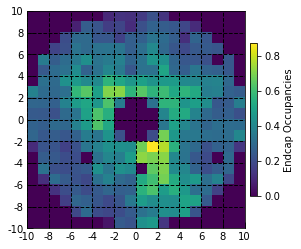

 >> AE-reco image:


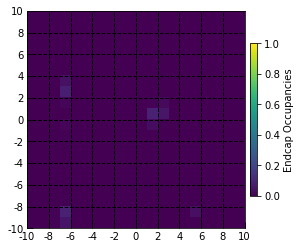

 >> loss map:


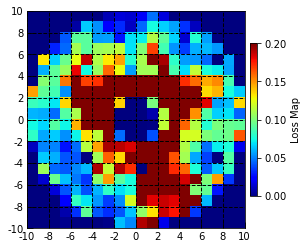

1: (0/2532) Train loss:0.098518, Emax: 0.871749, Erecomax: 0.092551
 >> original image:


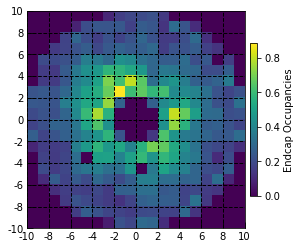

 >> AE-reco image:


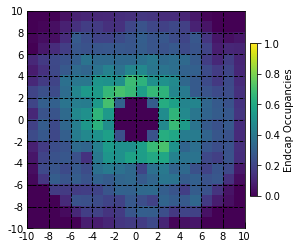

 >> loss map:


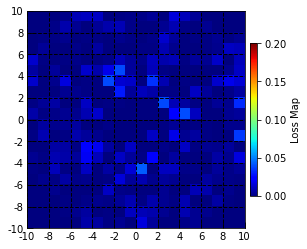

1: (100/2532) Train loss:0.005330, Emax: 0.883423, Erecomax: 0.712073
 >> original image:


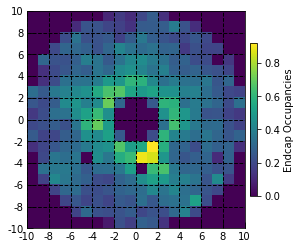

 >> AE-reco image:


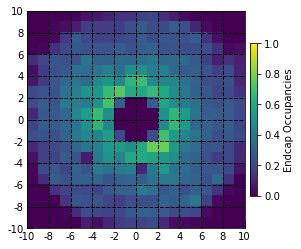

 >> loss map:


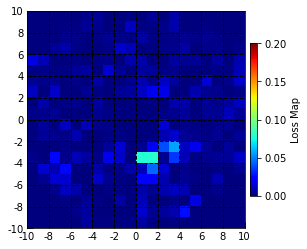

1: (200/2532) Train loss:0.004552, Emax: 0.918338, Erecomax: 0.775453
 >> original image:


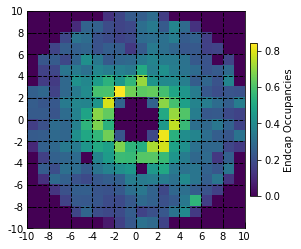

 >> AE-reco image:


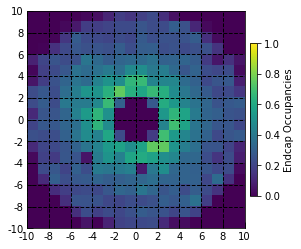

 >> loss map:


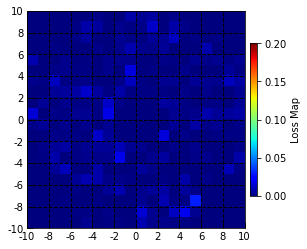

1: (300/2532) Train loss:0.003503, Emax: 0.841132, Erecomax: 0.757464
 >> original image:


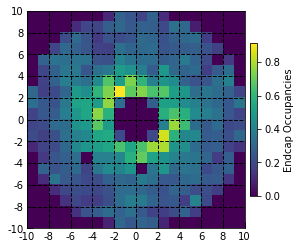

 >> AE-reco image:


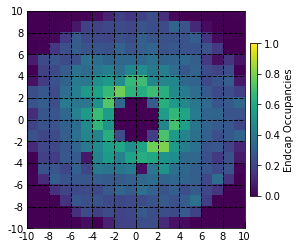

 >> loss map:


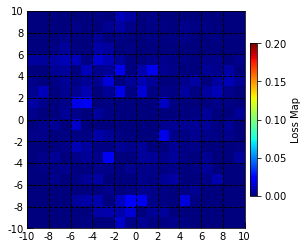

1: (400/2532) Train loss:0.003187, Emax: 0.912340, Erecomax: 0.801320
 >> original image:


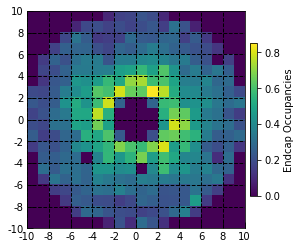

 >> AE-reco image:


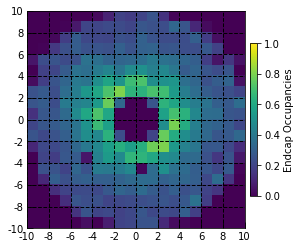

 >> loss map:


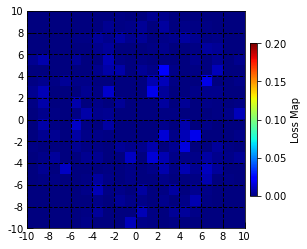

1: (500/2532) Train loss:0.002636, Emax: 0.850376, Erecomax: 0.807569
 >> original image:


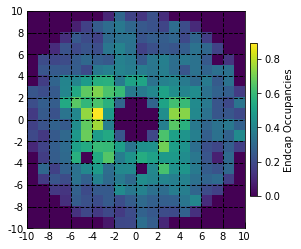

 >> AE-reco image:


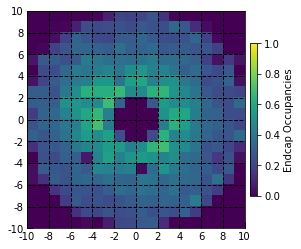

 >> loss map:


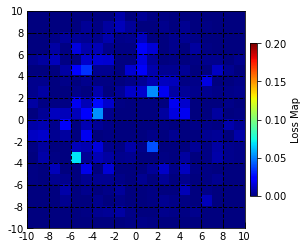

1: (600/2532) Train loss:0.002647, Emax: 0.892461, Erecomax: 0.700387
 >> original image:


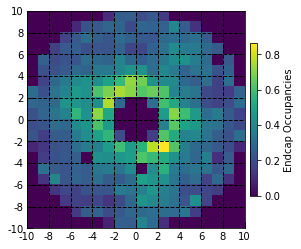

 >> AE-reco image:


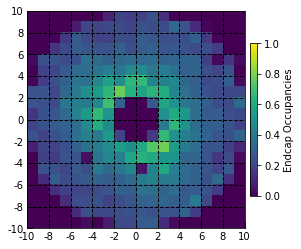

 >> loss map:


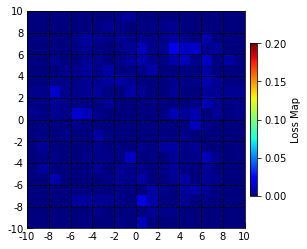

1: (700/2532) Train loss:0.002565, Emax: 0.861946, Erecomax: 0.784250
 >> original image:


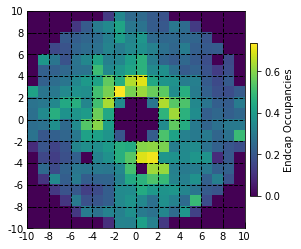

 >> AE-reco image:


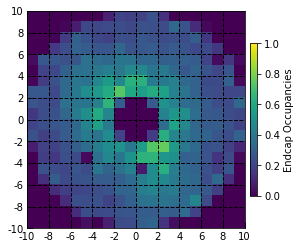

 >> loss map:


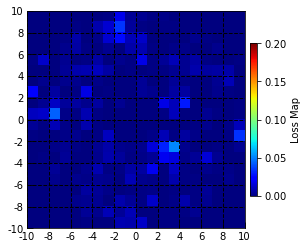

1: (800/2532) Train loss:0.002557, Emax: 0.735426, Erecomax: 0.764132
 >> original image:


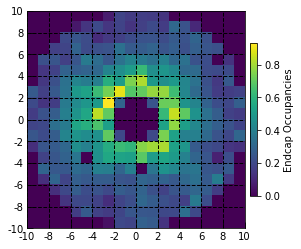

 >> AE-reco image:


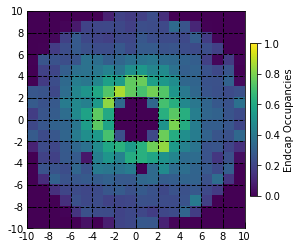

 >> loss map:


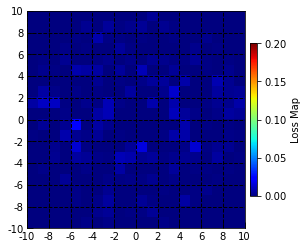

1: (900/2532) Train loss:0.002546, Emax: 0.929950, Erecomax: 0.874379
 >> original image:


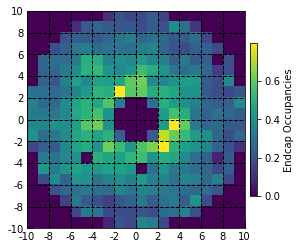

 >> AE-reco image:


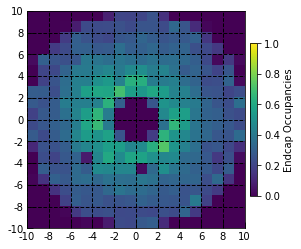

 >> loss map:


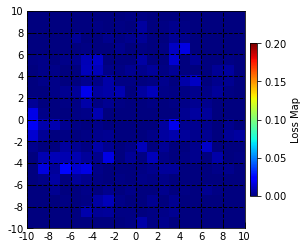

1: (1000/2532) Train loss:0.002392, Emax: 0.797119, Erecomax: 0.732935
 >> original image:


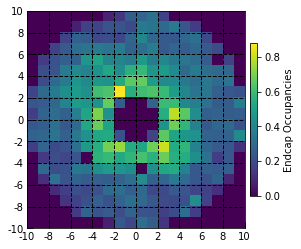

 >> AE-reco image:


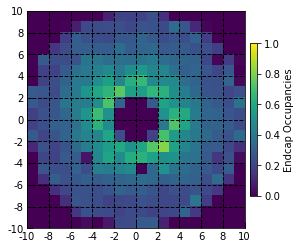

 >> loss map:


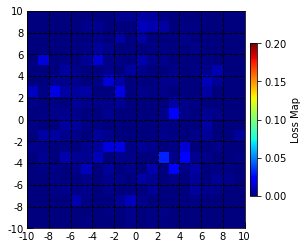

1: (1100/2532) Train loss:0.002358, Emax: 0.878248, Erecomax: 0.820132
 >> original image:


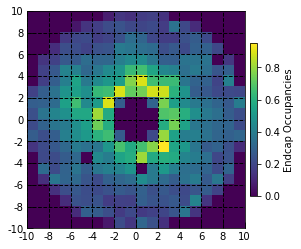

 >> AE-reco image:


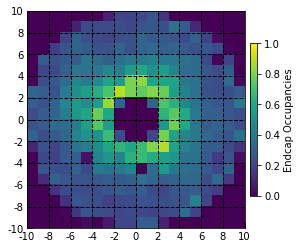

 >> loss map:


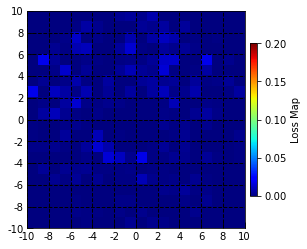

1: (1200/2532) Train loss:0.002249, Emax: 0.950858, Erecomax: 0.898334
 >> original image:


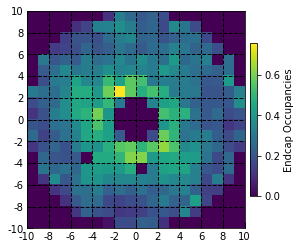

 >> AE-reco image:


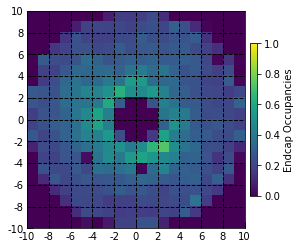

 >> loss map:


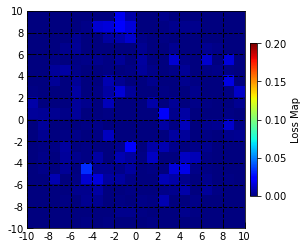

1: (1300/2532) Train loss:0.002508, Emax: 0.756659, Erecomax: 0.731351
 >> original image:


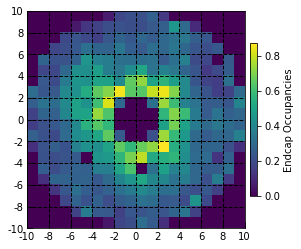

 >> AE-reco image:


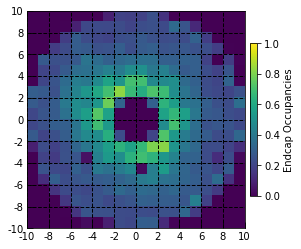

 >> loss map:


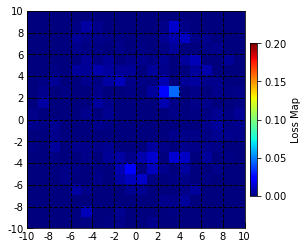

1: (1400/2532) Train loss:0.002111, Emax: 0.870457, Erecomax: 0.828656
 >> original image:


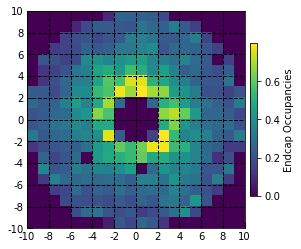

 >> AE-reco image:


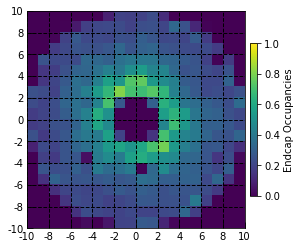

 >> loss map:


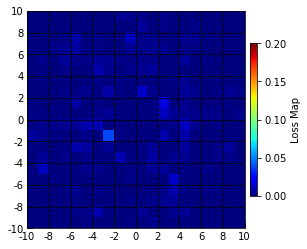

1: (1500/2532) Train loss:0.001936, Emax: 0.798672, Erecomax: 0.815123
 >> original image:


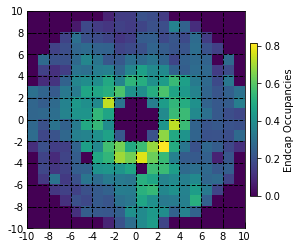

 >> AE-reco image:


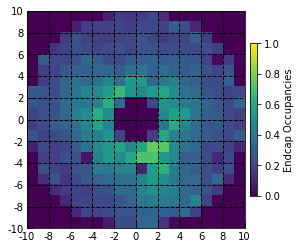

 >> loss map:


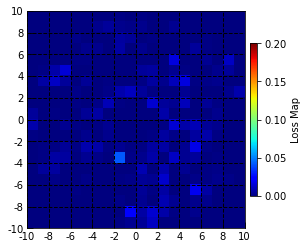

1: (1600/2532) Train loss:0.002037, Emax: 0.814597, Erecomax: 0.760877
 >> original image:


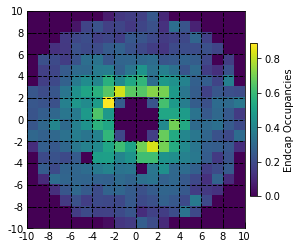

 >> AE-reco image:


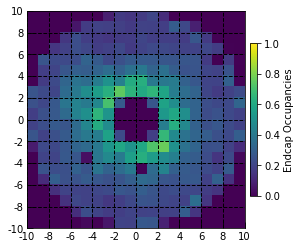

 >> loss map:


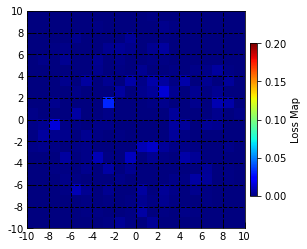

1: (1700/2532) Train loss:0.001956, Emax: 0.888217, Erecomax: 0.773137
 >> original image:


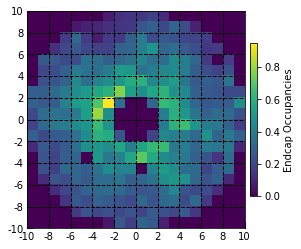

 >> AE-reco image:


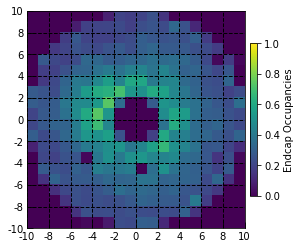

 >> loss map:


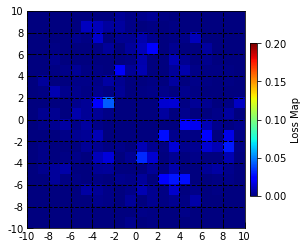

1: (1800/2532) Train loss:0.002308, Emax: 0.948217, Erecomax: 0.741266
 >> original image:


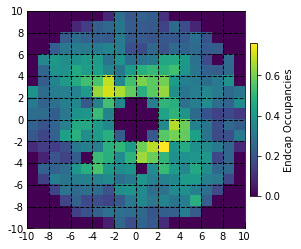

 >> AE-reco image:


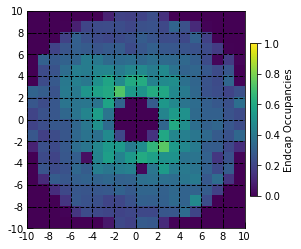

 >> loss map:


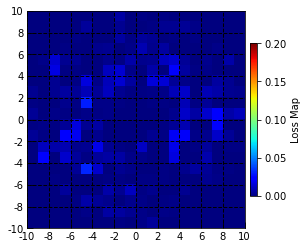

1: (1900/2532) Train loss:0.002127, Emax: 0.759787, Erecomax: 0.743462
 >> original image:


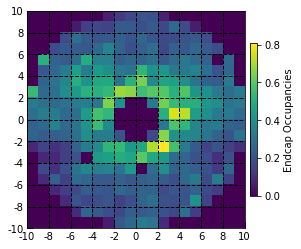

 >> AE-reco image:


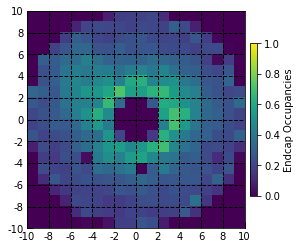

 >> loss map:


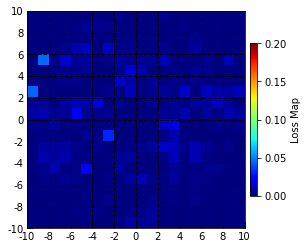

1: (2000/2532) Train loss:0.002289, Emax: 0.807449, Erecomax: 0.723677
 >> original image:


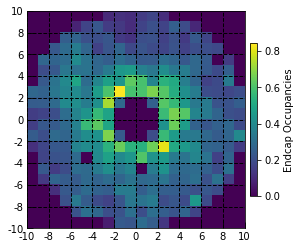

 >> AE-reco image:


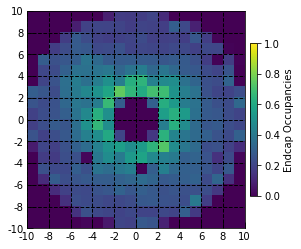

 >> loss map:


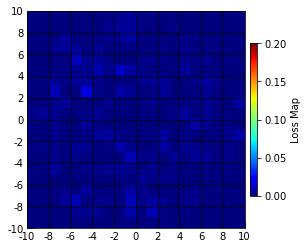

1: (2100/2532) Train loss:0.002276, Emax: 0.843633, Erecomax: 0.755394
 >> original image:


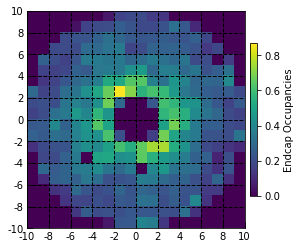

 >> AE-reco image:


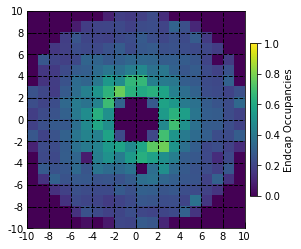

 >> loss map:


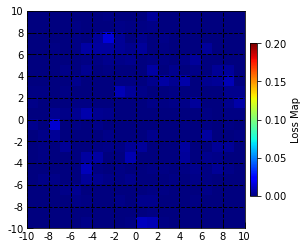

1: (2200/2532) Train loss:0.001926, Emax: 0.867798, Erecomax: 0.780114
 >> original image:


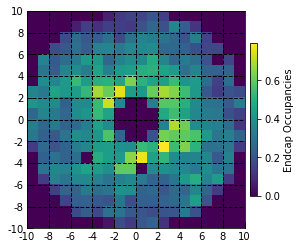

 >> AE-reco image:


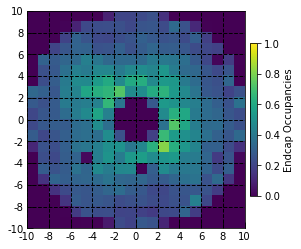

 >> loss map:


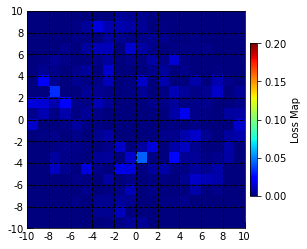

1: (2300/2532) Train loss:0.002098, Emax: 0.791512, Erecomax: 0.817903
 >> original image:


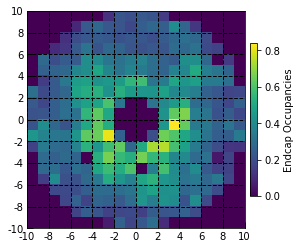

 >> AE-reco image:


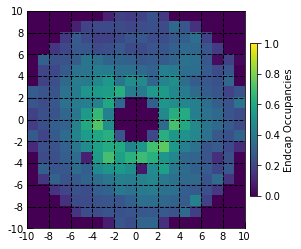

 >> loss map:


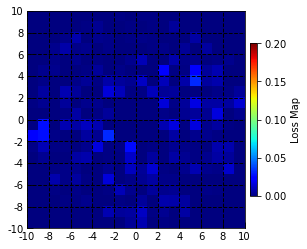

1: (2400/2532) Train loss:0.001936, Emax: 0.839906, Erecomax: 0.748477
 >> original image:


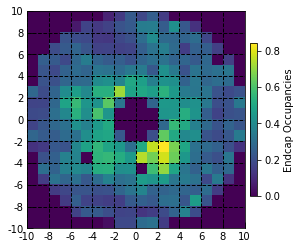

 >> AE-reco image:


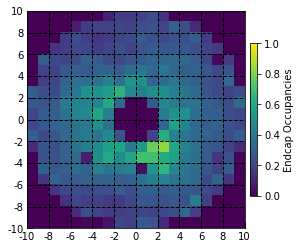

 >> loss map:


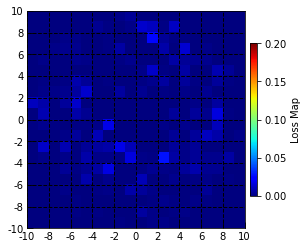

1: (2500/2532) Train loss:0.001869, Emax: 0.840247, Erecomax: 0.834097
1: Train time:1.11 min in 2532 steps
>> Validation: Good samples <<<<<<<<
 >> original image:


/export/home/phys/agermer/miniconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/export/home/phys/agermer/miniconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
/export/home/phys/agermer/miniconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in true_divide
/export/home/phys/agermer/miniconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
/export/home/phys/agermer/miniconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide
/export/home/phys/agermer/miniconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide


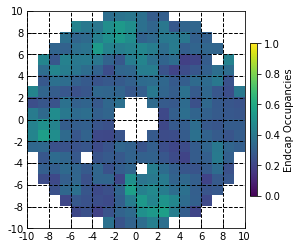

 >> AE-reco image:


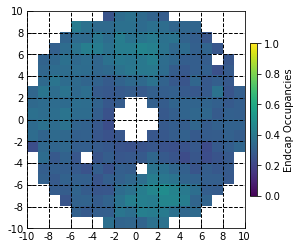

 >> loss map:
Anom coords: None


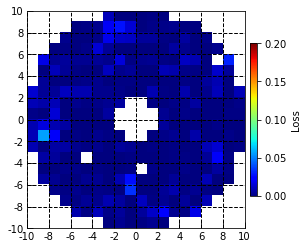

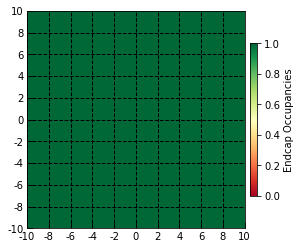

1: Val loss:nan, MAE: nan, N samples: 1047200 in 0.258263 min
LOW LOSS ANOMALIES: 


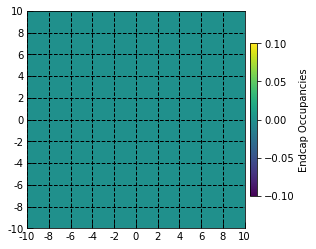

>> Validation: Anomaly samples <<<<<<<<
 >> original image:


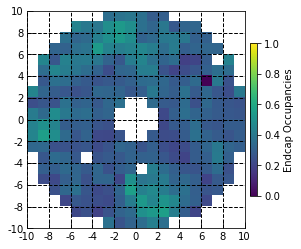

 >> AE-reco image:


In [ ]:
# Initialize AE model
ae = ResNetAE(1, 3, [16, 32])
ae.cuda()
# Initialize optimizer
optimizer = optim.Adam(ae.parameters(), lr=5.e-4)

#epochs = 50
monitor_step = 100

for e in range(epochs):

    epoch = e+1
    s = '>> Epoch %d <<<<<<<<'%(epoch)
    logger(s)
    print(s)

    # Run training
    ae.train()
    print(">> Training <<<<<<<<")
    logger(">> Training <<<<<<<<<")
    now = time.time()
    for i, data in enumerate(loader_train):
        X = data['EEOccupancyTask_EEOT_digi_occupancy_EE_m'].cuda()
        X = apply_PU_corr_batch(X, data['PU'])
        #print("pu size:", data['PU'].size())
        #print("i", i)
        #print("pu", data['PU'][i])
        # Reset gradient at each batch
        optimizer.zero_grad()
        # AE-reconstructed images
        Xreco = ae(X)
        # Batch-averaged loss
        loss = F.mse_loss(Xreco, X)
        '''
        For VAE:
        #Xreco, mu, logvar = ae(X)
        #loss, mse, kld = vae_loss(Xreco, X, mu, logvar)
        '''
        # Calculate backprop errors
        loss.backward()
        # Update network weights
        optimizer.step()
        # To monitor training progress during the epoch
        # explicity plot original and AE-reconstructed images for 0-th sample in every monitor_step batch
        # then plot the loss map
        if i % monitor_step == 0:
            # Original image:
            print(' >> original image:')
            img = X[0].cpu().numpy()
            plot_endcap(img, vmax = img.max())
            # AE-reconstructed image
            print(' >> AE-reco image:')
            img_reco = Xreco[0].detach().cpu().numpy()
            plot_endcap(img_reco)
            # Loss map
            print(' >> loss map:')
            img_loss = F.mse_loss(Xreco[0], X[0], reduction='none').detach().cpu().numpy()
            plot_endcap(img_loss, vmax=0.2, cmap='jet', label='Loss Map')
            s = ('%d: (%d/%d) Train loss:%f, Emax: %f, Erecomax: %f'%(epoch, i, len(loader_train), loss.item(), img.max(), img_reco.max()))
            print(s)
            logger(s)
        #if i != 0 and i % 10 == 0: break
        #if i >= 2: break

    now = time.time() - now
    s = '%d: Train time:%.2f min in %d steps'%(epoch, now/60, len(loader_train))
    print(s)
    logger(s)

    # Run Validation
    ae.eval()
    print(">> Validation: Good samples <<<<<<<<")
    logger(">> Validation: Good samples <<<<<<<<")
    good_losses = do_eval(ae, loader_val, epoch)
    #do_eval(ae, loader_val, epoch)
    print(">> Validation: Anomaly samples <<<<<<<<")
    logger(">> Validation: Anomaly samples <<<<<<<<")
    anom_losses = do_eval(ae, loader_val, epoch, anom = True)
    #do_eval(ae, loader_anom, epoch, anom = True)
    
    plt.clf()
    plt.hist(anom_losses, histtype='step',range=(0,anom_losses.max()),bins=240,log=True, label='Anom Loss', color='orange',linewidth='4')
    plt.hist(good_losses, histtype='step',range=(0,anom_losses.max()),bins=240,log=True, label='Good Loss', color='purple',linewidth='2')
    plt.legend()
    plt.xlabel('AE Loss', size='14')
    plt.savefig('lossmap.png', bbox_inches='tight')
    plt.show()
    
    FNR, FDR, allanom_thresh, allgood_thresh = get_roc(good_losses, anom_losses,use_thresh=False) 
    print("False negative rate: ", FNR)
    logger(f'False negative rate: {FNR}')
    print(f"False discovery rate: {FDR}")
    logger(f"False discovery rate: {FDR}")
    
    # TODO: Make some plots showing rate of false positives, false negatives, etc.
if run_logger:
    file.close()